In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

import pandas as pd

In [2]:
path = 'C:/Users/sanghui/Desktop/toyproject/DL_Project_5/hsh/data/2_15_crop'

In [3]:
len(os.listdir(path))

51260

In [4]:
# load data
img_datas = []

for filename in tqdm_notebook(os.listdir(path)):
    file_path = path + '/' + filename
    src = cv2.imread(file_path, cv2.IMREAD_COLOR)
    img_datas.append(src)

img_datas = np.array(img_datas)
img_datas.shape
    

C:\Users\sanghui\AppData\Local\Temp/ipykernel_1140/49376284.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for filename in tqdm_notebook(os.listdir(path)):


  0%|          | 0/51260 [00:00<?, ?it/s]

(51260, 224, 224, 3)

In [5]:
# np.save('C:/Users/sanghui/Desktop/toyproject/DL_Project_5/hsh/2_15', img_datas)

---

# Feature Extraction

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

base_model = InceptionV3(weights='imagenet', include_top=True)
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [7]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

In [9]:
features = []

for img in tqdm_notebook(img_datas):
    dst = cv2.resize(img, dsize=(299,299), interpolation=cv2.INTER_CUBIC) #상대적으로 선명한 이미지를 위하여
    img_data = np.expand_dims(dst, axis=0)
    img_data = preprocess_input(img_data)

    features.append(model.predict(img_data)[0])

C:\Users\sanghui\AppData\Local\Temp/ipykernel_1140/211145580.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm_notebook(img_datas):


  0%|          | 0/51260 [00:00<?, ?it/s]

---

# Clustering

In [11]:
latent_vector = np.array(features)

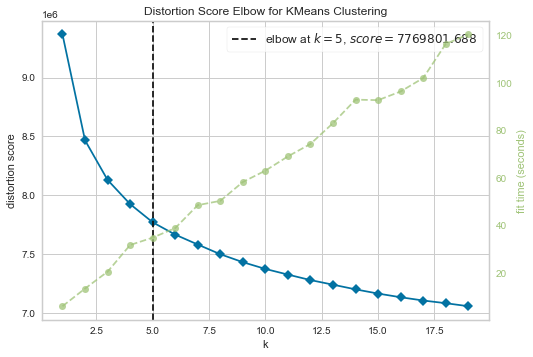

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
# elbow score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

km = KMeans()
visualizer = KElbowVisualizer(km, k=(1,20))
visualizer.fit(latent_vector)
visualizer.show()

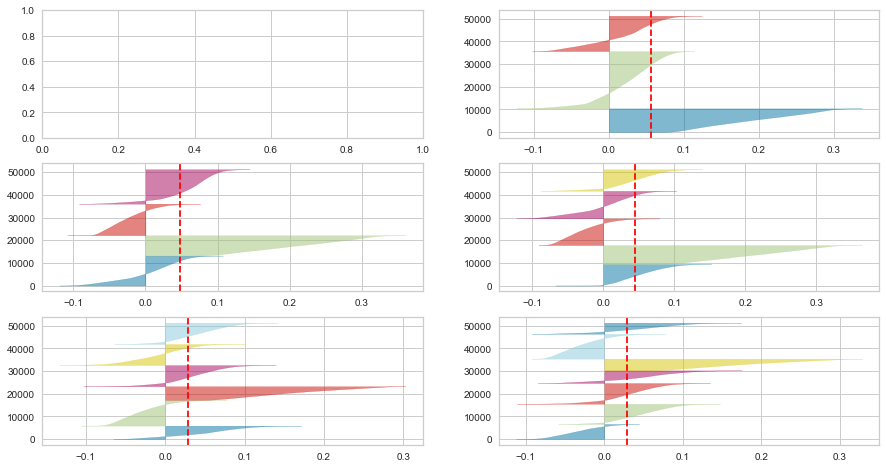

In [13]:
# SilhouetteVisualizer

from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [3, 4, 5, 6, 7]:
    
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(latent_vector) 

In [15]:
from sklearn.metrics import silhouette_score

km = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=100, random_state=42).fit(latent_vector)
print(f'Silhouette score: {silhouette_score(latent_vector, km.labels_)}')

Silhouette score: 0.04461831972002983


In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_fit = pca.fit_transform(latent_vector)

pca_result = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
pca_result['Clusters'] = km.labels_
pca_result.head()

,PCA1,PCA2,Clusters
0,2.252295,-5.206020,0
1,-2.112430,0.851844,4
2,-2.850044,0.161457,0
3,-1.988121,-1.949693,0
4,-5.094435,0.041668,2


Text(0.5, 1.0, 'Personality Clusters after PCA')

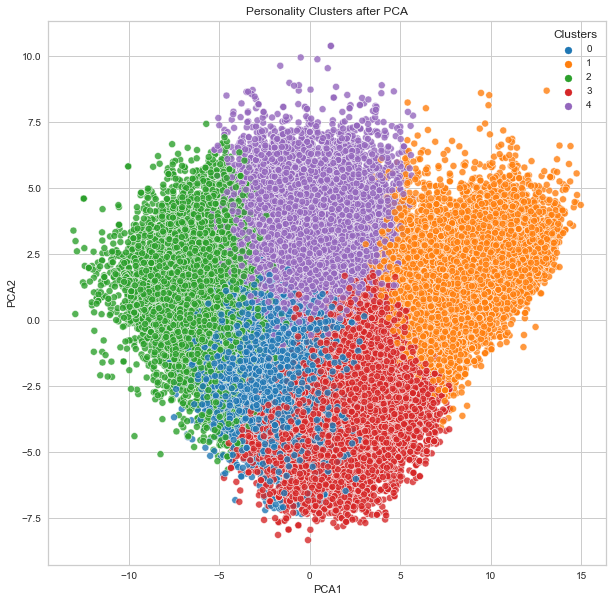

In [23]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.scatterplot(data=pca_result, x='PCA1', y='PCA2', hue='Clusters', palette='tab10', alpha=0.8)
plt.title('Personality Clusters after PCA')

In [26]:

# from sklearn.manifold import TSNE

# perplexities = [5, 10, 15, 25, 50]
# plt.figure(figsize=(8, 12))

# for c in tqdm_notebook(range(5)):
#     pca = PCA(n_components=2)
#     data = pca.fit_transform(latent_vector)
#     tsne = TSNE(n_components=2, perplexity=perplexities[c], random_state=42, learning_rate=0.1)
#     tsne_vector = tsne.fit_transform(data)

#     plt.subplot(3, 2, c+1)
#     plt.scatter(tsne_vector[:, 0], tsne_vector[:, 1], marker='.', cmap='rainbow')
#     plt.title(f'perplexity: {perplexities[c]}')

In [27]:
km.cluster_centers_

array([[0.38171357, 0.4687618 , 0.60697675, ..., 0.34798002, 0.74775684,
        0.27063143],
       [0.06150672, 0.26490593, 0.08546776, ..., 0.47276595, 0.1790685 ,
        0.8586972 ],
       [0.2658564 , 0.41504607, 0.5048069 , ..., 0.39455745, 0.7523792 ,
        0.376684  ],
       [0.28140724, 0.33982915, 0.30484492, ..., 0.41088897, 0.2993261 ,
        0.32611743],
       [0.12092499, 0.35114297, 0.26307815, ..., 0.3386805 , 0.6714871 ,
        0.4193251 ]], dtype=float32)

In [29]:
km.cluster_centers_[0].shape

(2048,)

In [47]:
km.labels_.shape

(51260,)

In [30]:
latent_vector[0].shape

(2048,)

In [31]:
vector_df = pd.DataFrame(latent_vector, index=os.listdir(path))
vector_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0.jpg,0.538921,0.277842,0.211032,0.688597,0.185452,0.011790,0.730540,1.207996,0.353460,0.943377,...,0.650954,0.384054,0.161039,0.020428,0.108557,0.375065,0.752276,0.228633,0.100316,0.238573
1.jpg,0.034592,0.369639,0.285800,0.384725,0.161416,0.087499,0.072540,0.054384,0.099075,1.104054,...,0.542958,0.070208,0.417268,0.411512,0.309312,0.799908,0.390913,0.036137,0.323454,0.408953
10.jpg,0.327455,0.172024,0.471271,0.691185,0.073252,0.192843,0.303251,0.252891,0.429027,0.816513,...,0.594970,0.181632,0.111094,0.906809,0.254723,1.594207,1.123552,0.449776,0.011376,0.476047
100.jpg,0.455779,0.937296,1.336042,0.189010,0.308206,0.088695,0.333553,0.254512,0.093298,0.683606,...,0.188897,0.117677,0.881172,1.004324,0.065228,0.354559,0.178113,0.522083,0.709399,0.235006
1000.jpeg,0.158576,0.593128,0.319609,0.634666,0.258412,0.307201,0.383449,1.362908,0.106569,0.599014,...,0.055395,0.058772,0.323253,1.327696,0.239198,0.122088,1.716506,0.229803,1.230238,0.292252


In [48]:
vector_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51260 entries, 0.jpg to 9999.jpg
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 402.9+ MB


In [49]:
vector_df['cluster'] = km.labels_
vector_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,cluster
0.jpg,0.538921,0.277842,0.211032,0.688597,0.185452,0.011790,0.730540,1.207996,0.353460,0.943377,...,0.384054,0.161039,0.020428,0.108557,0.375065,0.752276,0.228633,0.100316,0.238573,0
1.jpg,0.034592,0.369639,0.285800,0.384725,0.161416,0.087499,0.072540,0.054384,0.099075,1.104054,...,0.070208,0.417268,0.411512,0.309312,0.799908,0.390913,0.036137,0.323454,0.408953,4
10.jpg,0.327455,0.172024,0.471271,0.691185,0.073252,0.192843,0.303251,0.252891,0.429027,0.816513,...,0.181632,0.111094,0.906809,0.254723,1.594207,1.123552,0.449776,0.011376,0.476047,0
100.jpg,0.455779,0.937296,1.336042,0.189010,0.308206,0.088695,0.333553,0.254512,0.093298,0.683606,...,0.117677,0.881172,1.004324,0.065228,0.354559,0.178113,0.522083,0.709399,0.235006,0
1000.jpeg,0.158576,0.593128,0.319609,0.634666,0.258412,0.307201,0.383449,1.362908,0.106569,0.599014,...,0.058772,0.323253,1.327696,0.239198,0.122088,1.716506,0.229803,1.230238,0.292252,2


In [51]:
vector_df.value_counts('cluster')

cluster
3    12155
2    11752
4     9528
0     9489
1     8336
dtype: int64

In [44]:
import math

# 유클리드 거리계산
# 각 클러스터 중심까지의 거리 계산
# 클러스터 중심점으로 부터 거리 최소 = 해당 클러스터
def euclidean_distance(x, y):
    return math.sqrt(sum(pow(a - b, 2) for a, b in zip(x, y)))

In [45]:
euclidean_distance(km.cluster_centers_[0], vector_df[0])

14.972614063394145

In [53]:
save_df = vector_df.reset_index()
save_df = save_df.rename(columns={'index': 'filename'})
save_df.head()

,filename,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,cluster
0,0.jpg,0.538921,0.277842,0.211032,0.688597,0.185452,0.011790,0.730540,1.207996,0.353460,...,0.384054,0.161039,0.020428,0.108557,0.375065,0.752276,0.228633,0.100316,0.238573,0
1,1.jpg,0.034592,0.369639,0.285800,0.384725,0.161416,0.087499,0.072540,0.054384,0.099075,...,0.070208,0.417268,0.411512,0.309312,0.799908,0.390913,0.036137,0.323454,0.408953,4
2,10.jpg,0.327455,0.172024,0.471271,0.691185,0.073252,0.192843,0.303251,0.252891,0.429027,...,0.181632,0.111094,0.906809,0.254723,1.594207,1.123552,0.449776,0.011376,0.476047,0
3,100.jpg,0.455779,0.937296,1.336042,0.189010,0.308206,0.088695,0.333553,0.254512,0.093298,...,0.117677,0.881172,1.004324,0.065228,0.354559,0.178113,0.522083,0.709399,0.235006,0
4,1000.jpeg,0.158576,0.593128,0.319609,0.634666,0.258412,0.307201,0.383449,1.362908,0.106569,...,0.058772,0.323253,1.327696,0.239198,0.122088,1.716506,0.229803,1.230238,0.292252,2


In [54]:
save_df.to_csv('clustering.csv', encoding='utf-8')

In [56]:
cluster_center = km.cluster_centers_
cluster_center[0]

array([0.38171357, 0.4687618 , 0.60697675, ..., 0.34798002, 0.74775684,
       0.27063143], dtype=float32)

In [68]:
distances = []

for i, row in tqdm_notebook(save_df.iterrows()):
    distance = euclidean_distance(cluster_center[row['cluster']], row[1:-1])
    distances.append(distance)


C:\Users\sanghui\AppData\Local\Temp/ipykernel_1140/2629899406.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm_notebook(save_df.iterrows()):


0it [00:00, ?it/s]

In [69]:
save_df['center_distance'] = distances

In [70]:
save_df.to_csv('clustering2.csv', encoding='utf-8')